# Scope analysis 

## Imports and other required functions

In [1]:
#Import needed libraries
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import csv
import datetime
import os,platform
from scipy.optimize import curve_fit
import scipy
from scipy.fft import fft, rfft, irfft,ifft,fftfreq
from scipy.signal import argrelextrema
from scipy.stats import norm
from lmfit.models import SkewedGaussianModel


#varible for determining the lab pc or other pc, Check if windows or not, then try to grab pc name
pcname=""
if platform.system() == "Windows":
    pcname=platform.uname().node
else:
    try:
        pcname=os.uname()[1]
    except:
        print("Issue with finding pc name")

env_var_wavefromloc ="" #varible for location of waveform data. 
data_dir_mod_old="" #varible for small difference in storage managment between pc 1 and 2
if pcname=='PHYS-PSB02802': #Lab pc 2, (Labview pc)
    env_var_wavefromloc ="A:/DATA/waveforms/"
    env_var_waveformloc_old="C:/Users/KK_Lab28_1/Documents/Waveforms/"
    data_dir_mod_old=""

elif pcname=="PHYS-PSB02801": #Lab pc 1, (solidworks pc)
    env_var_wavefromloc ="data/waveforms/" #This is true for Jason's work atm (June 10th) Needs Updateing to global or user friendly verison
    data_dir_mod_old="/"
##############################

waveform_path="C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/data/waveforms/" # Path for data On left pc


#Read in runlist and change cols to numbers
def ReadRunlist(filename="C:/Users/jasonbane/Desktop/nexo_code/Run Data (GUI v1)/RunList.csv"):
    return pd.read_csv(filename,index_col=False)

Runlist_DF = ReadRunlist()
Runlist_DF["RN"]=Runlist_DF["Run No."]
number_cols=["Anode V.","Anode Grid V.","Cathode V.","Cathode Grid V.","Drift Length"]
Runlist_DF[number_cols] = Runlist_DF[number_cols].apply(pd.to_numeric)

# Read in Drift stack measurment database for drift, ext, col lengths and errors
Distance_Database=pd.read_csv("C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/CellDistanceDataBase.csv")
Distance_Database["Date"] = Distance_Database["Date"].astype(str)
Distance_Database["Date"] = pd.to_datetime(Distance_Database["Date"])


# Add in distance to run list and calc fields
if 1==1:
#def runlist_distance_fix():
    global Runlist_DF
    global Distance_DataBase

    skip=0
    for i,run in enumerate(Runlist_DF["Run No."][skip:]):
        
        Date = pd.to_datetime(Runlist_DF["Date"].iloc[i+skip],format='%Y%m%d')
        # Date = datetime.datetime(Date)
        
        DF =Distance_Database[Distance_Database["Date"]<= Date].iloc[0]
        

        for key in DF.keys()[1:]:
            
            Runlist_DF.loc[i+skip,key] = DF[key]



Runlist_DF["Drift Field"] = (Runlist_DF["Cathode Grid V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Drift Length"]/10.0)
Runlist_DF["Extraction Field"] = (Runlist_DF["Cathode V."] - Runlist_DF["Cathode Grid V."])/(Runlist_DF["Extraction Distance"]/10.0)
Runlist_DF["Collection Field"] = (Runlist_DF["Anode V."] - Runlist_DF["Anode Grid V."])/(Runlist_DF["Collection Distance"]/10.0)


#Bg database
bgdb=pd.read_csv("C:/Users/jasonbane/Desktop/nexo_code/nexo/Lab028/osci/bg_db.csv")


#make blank dataframe for background subtraction debugging
blankBG_DF= pd.DataFrame({"Avg Anode":[0]*50000})

### Functions for fitting, Runinfo and waveform gathering

In [2]:
# Gaussian function definition
def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
def logarithmic_model(x, a, b):
    return a * np.log(b * x)

def dg(x,a,mu_a,sigma_a,m,b):
    return a * np.exp(-(x - mu_a) ** 2 / (2 * sigma_a ** 2)) +   (m + x*b)


# Define the skewed Gaussian function
def skewed_gaussian(x, alpha, mu, sigma, amplitude):
    # Standard normal PDF
    pdf = amplitude * (2 / sigma) * norm.pdf((x - mu) / sigma)
    # Skew factor
    cdf = norm.cdf(alpha * (x - mu) / sigma)
    return pdf * cdf

def errfunc(x, a, b, z, f):
    return a * scipy.special.erf((x - z)*f) + b

#Function to retrieve run list information
def GetRunInfo(runnumber, old=False):
    global Runlist_DF
    if old:
        print("not set up yet")
        return -1
    
    DF=Runlist_DF.query('`Run No.`== %f'%(runnumber))

    if len(DF)==0:
        print("That run not in list")
        return 0
    else:
        return DF
    

def GetBGRun(run):
    global bgdb
    try:
        return bgdb.query("run==%i"%(run)).iloc[0]["background"]
    except:
        return -1

In [ ]:
def GetWaveForm(runnumber,wavenumber=10):
    global waveform_path
    RI = GetRunInfo(runnumber) 
    if type(RI)==type(0): #Make sure run is in runlist
        return 0
    waveform_date ="%i"%(RI["Date"].iloc[0])
    runnumber="%05i"%(runnumber)

    # For left PC
    waveform_dir=waveform_path+waveform_date+"/"+waveform_date+"-"+runnumber
    waveform_wavenumber="%s"%(wavenumber)

    waveform_filename=waveform_date+"-"+runnumber+"_"+"*"+waveform_wavenumber
    waveform_fullpath_wild=waveform_dir+"/"+waveform_filename+".csv"
    try: 
        waveform_fullpath=glob.glob(waveform_fullpath_wild )[-1].replace("\\","/")
    except:
        waveform_fullpath=glob.glob(waveform_dir+"/"+waveform_date+"-"+runnumber+"_"+"*" )[-1].replace("\\","/")
    
    if os.path.exists(waveform_fullpath):
        # Grab the second line and define the units of each column
        unit_line=open(waveform_fullpath).readlines()[1]
        units=unit_line.replace("(","").replace(")","").strip().split(",")
        #Build DF from csv
        DF=pd.read_csv(waveform_fullpath,skiprows=[1])
        # Convert to ms and mV
        for i,key in enumerate(DF.keys()):
            if units[i] == "V":
                DF[key]=DF[key]*1000 
            if units[i] == "ms":
                print("time convertion")
                DF[key]=DF[key]*1000 
        # rename columns
        DF=ReNameCols(DF)
        return DF
    else: # Did not find file
        print("Issue with file")
        return 0
    

# this should correct the colomn names of the avg cath and anode. need to add incorrect options to list
def ReNameCols(DF):
    chann_name_options=[["Avg UV","Avg Anode"],
                        ['Average Cathode (2)', 'Average Anode (2)'],
                        ['average(Cathode)', 'average(Anode)']]
    Correct_names=["Avg Cathode","Avg Anode"]
    keys=DF.keys()
    if Correct_names[0] in keys and Correct_names[1] in keys:
        return DF
    for chan_options in chann_name_options:
        if chan_options[0] in keys:
            DF =DF.rename(columns={chan_options[0]: Correct_names[0]})
        if chan_options[1] in keys:
            DF =DF.rename(columns={chan_options[1]: Correct_names[1]})

    return DF






In [33]:
analysis_list=[]

## Building fitting and plotting functions for a run

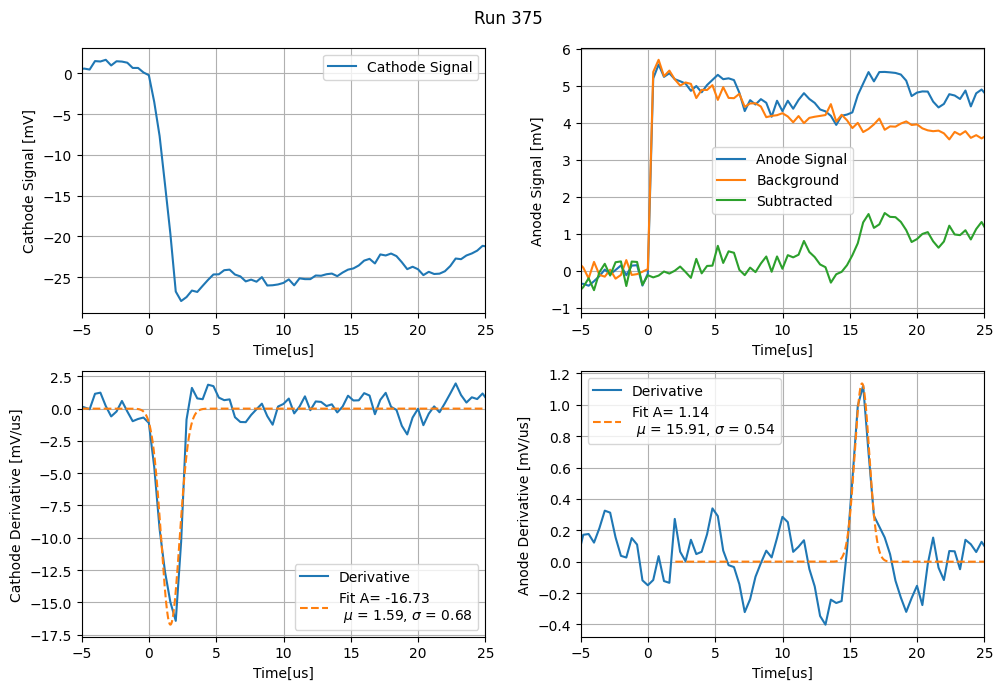

In [34]:
#Will need to make argruments
debug =0
plot = True
savefig=True


runlist=[375]
#bg_runs=[335]

stepcount=100
diffsizes =[200]

anode_delay=[]
cathode_delay=[]
drift_field_list=[]
k=0
for k,diffsize in enumerate(diffsizes):
    i=0
    for j,run in enumerate(runlist):

        analysis_dict={}
        bg_run=GetBGRun(run)
        if debug >= 1: print("Run " , run, "  BG- ", bg_run)
       
        # Grab the main and background waveforms
        try:
            DF=GetWaveForm(run)
        except:
            print("Issue with run " ,run)
            continue
        try:
            if bg_run ==-1:
                n=len(DF["Time"])
                bgDF=pd.DataFrame({"Avg Cathode": [0] *n , "Avg Anode": [0] * n})
            else:
                bgDF=GetWaveForm(bg_run)
        except Exception as e:
            print(f"An error occurred: {e}")
            print("Issue with bg " , bg_run)
            continue

        if plot: fig, ax = plt.subplots(2,2, figsize=(10,7))
            
        timeresolution = DF["Time"].iloc[1] - DF["Time"].iloc[0]
        if debug >=4: print("Time step size: ", round(timeresolution,5))
        RI = GetRunInfo(run)
        drift_field=RI["Drift Field"].iloc[0]
        bgRI = GetRunInfo(bg_run)

        # Find the baseline normalization of each waveform
        mod_step=int((stepcount * 0.004/timeresolution))
        res_mod=0.004/timeresolution
        Zero_time = np.where(abs(DF["Time"] - 0) <= 10*timeresolution)[0][-1] #Time 0 +2

        #Get Normalizations for setting baseline to zero
        anodenorm=np.average(DF["Avg Anode"][Zero_time-int(100*res_mod):Zero_time-int(10*res_mod)])
        cathnorm =np.average(DF["Avg Cathode"][Zero_time-int(100*res_mod):Zero_time-int(10*res_mod)])
        bg_anorm =np.average(bgDF["Avg Anode"][Zero_time-int(100*res_mod):Zero_time-int(10*res_mod)])
        bg_cnorm =np.average(bgDF["Avg Cathode"][Zero_time-int(100*res_mod):Zero_time-int(10*res_mod)])

        #Normalize signal and BG then subtract, make correct o bg if too big
        bg_y_factor=1
        anode_sig=DF["Avg Anode"] - anodenorm
        bg_a_sig =bgDF["Avg Anode"] - bg_anorm
        if np.max(bg_a_sig[:3000]) > np.max(anode_sig[:3000]):
            if debug >=10: print("bg too big")
            bg_y_factor= np.max(anode_sig[:3000])/np.max(bg_a_sig[:3000])
        anode_sub= anode_sig-bg_a_sig[:len(anode_sig)]*bg_y_factor

        #take diff
        rolling= anode_sub.rolling(mod_step).mean()
        if debug >=10: print("modifed diffsize ",int(diffsize*res_mod))
        anode_diff = rolling.diff(int((diffsize*res_mod)))/(DF["Time"].iloc[int((diffsize*res_mod))]-DF["Time"].iloc[0])

        #Plot 
        if plot: 
            ax[0][1].errorbar(x=DF["Time"][::mod_step],y=anode_sig[::mod_step],  label="Anode Signal")
            ax[0][1].errorbar(x=DF["Time"][::mod_step],y=bg_a_sig[::mod_step]*bg_y_factor,  label="Background")
            ax[0][1].errorbar(x=DF["Time"][::stepcount],y=anode_sub[::stepcount],  label="Subtracted")
            ax[1][1].errorbar(x=DF["Time"][::stepcount],y=anode_diff[::stepcount],  label="Derivative")

        #Fit the derivative with a guassian
        fit_start_index = np.where(abs(DF["Time"] - 0) <= 10*timeresolution)[0][-1] + int(2/timeresolution) #Time 0 +2
    
        #P0 for guassian fit
        #P0 for amp
        diff_max=np.max(anode_diff[fit_start_index:]) #Amp value
        max_loc_ind = np.where(anode_diff == diff_max)[0] #index for max location
        max_time= np.array(DF["Time"])[max_loc_ind]    # time for the max location
        
        #P0 for sigma 
        half_max_ind=[]
        k=0
        while len(half_max_ind) <=1:
            half_max_ind= (np.where(abs(anode_diff[fit_start_index:] - diff_max/2.0) <= 0.01*(k+1)) + fit_start_index)[0] #indexes for simga guess
            k=k+1
            if k >=25:
                print("Cant find second half max for anode")
                break
        try :
            half_max_sep = DF["Time"].iloc[half_max_ind[-1]] - DF["Time"].iloc[half_max_ind[0]]  # seperation between first and last index
        except : 
            half_max_sep = timeresolution*4 #why 4? Need to address !flag!
       
        #anode Fitting data
        xfit = np.array(DF["Time"][fit_start_index:])
        yfit = np.array(anode_diff[fit_start_index:].fillna(0))
               
        p0 = [diff_max,max_time[0],half_max_sep/2]
        if debug >=5: print("Anode p0 ", np.round(p0,4))

        # Set up to loop through a few fitting attempts
        max_fits, sigma,A,z= 10,10,0,0
        Amp=diff_max    
        xfit_tmp=xfit
        yfit_tmp=yfit
    
        while sigma >=1 or abs((A-Amp))/Amp >= 0.1:
            ppot, pcov = curve_fit(gaussian,xfit_tmp,yfit_tmp, p0=p0,maxfev = 2000)
            z=z+1
            sigma=ppot[2]
            A=ppot[0]
            if z >=max_fits:
                break
            #adjust fitting range to attempt a new fit
            yfit_tmp = yfit[np.max([max_loc_ind[0]-(max_fits-z)*500,0]):np.min([max_loc_ind[0]+(max_fits-z)*500,len(yfit)])].copy()
            xfit_tmp = xfit[np.max([max_loc_ind[0]-(max_fits-z)*500,0]):np.min([max_loc_ind[0]+(max_fits-z)*500,len(xfit)])].copy()

        if ppot[0] <0:
            print("Bad fit skipping run ", run)
            continue

               
        #plot the guassian
        if plot: 
            guass_y = gaussian(xfit,ppot[0],ppot[1],ppot[2])
            ax[1][1].errorbar(x=xfit,y=guass_y,fmt="--",
                          label="Fit A= %0.2f \n $\mu$ = %0.2f, $\sigma$ = %0.2f"%(ppot[0],ppot[1],ppot[2]))

            ax[0][0].errorbar(x=DF["Time"][::mod_step],
                          y=DF[chann_names[0]][::mod_step] - cathnorm,   label="Cathode Signal")


        #Cathode analysis
        #Normalize signal and BG then subtract
        cath_sig=DF[chann_names[0]] - cathnorm
        
        cath_diff = cath_sig.diff(int(diffsize*res_mod))/(DF["Time"].iloc[int(diffsize*res_mod)]-DF["Time"].iloc[0])
        
        if plot: ax[1][0].errorbar(x=DF["Time"][::mod_step],y=cath_diff[::mod_step],   label="Derivative")
        
        #Cathode Fitting data
        xfit = np.array(DF["Time"][:])
        yfit = np.array(cath_diff[:].fillna(0))
        
        #guess for cathode fit

        min_loc_ind = np.where(cath_diff == np.min(cath_diff)) #index for max locaiton
        min_time= np.array(DF["Time"])[min_loc_ind][0]

        k=0
        half_min_ind=[]
        while len(half_min_ind) <=1:
            half_min_ind= (np.where(abs(cath_diff - np.min(cath_diff)/2.0) <= 0.2*k) )[0] #indexes for simga guess
            k=k+1
            if k >=45:
                print("Cant find second half max")
                break
        
        half_min_sep = DF["Time"].iloc[half_min_ind[-1]] - DF["Time"].iloc[half_min_ind[0]]  # seperation between first and last index
        
        
        p0 = [np.min(yfit),min_time,half_min_sep]
        if debug >=5: print("cathode p0", np.round(p0,4))
        #Fit cathode deriv
        ppot, pcov = curve_fit(gaussian,xfit,yfit, p0=p0)


        if plot:
            guass_y = gaussian(xfit,ppot[0],ppot[1],ppot[2])
            ax[1][0].errorbar(x=xfit,y=guass_y,fmt="--",
                          label="Fit A= %0.2f \n $\mu$ = %0.2f, $\sigma$ = %0.2f"%(ppot[0],ppot[1],ppot[2]))

            ax[1][0].grid()
            ax[1][0].legend()
            ax[1][0].set_xlabel("Time[us]")
            ax[1][0].set_ylabel("Cathode Derivative [mV/us]")
            ax[1][0].set_xlim(-5,25)

            ax[1][1].grid()
            ax[1][1].legend()
            ax[1][1].set_xlabel("Time[us]")
            ax[1][1].set_ylabel("Anode Derivative [mV/us]")
            ax[1][1].set_xlim(-5,25)

            ax[0][0].grid()
            ax[0][0].legend()#loc="upper right")
            ax[0][0].set_xlabel("Time[us]")
            ax[0][0].set_ylabel("Cathode Signal [mV]")
            ax[0][0].set_xlim(-5,25)

            ax[0][1].grid()
            ax[0][1].legend()#loc="upper right")
            ax[0][1].set_xlabel("Time[us]")
            ax[0][1].set_ylabel("Anode Signal [mV]")
            ax[0][1].set_xlim(-5,25)
        
            fig.suptitle("Run %i"%(run))
            plt.tight_layout()


        # Need to develop funciton to check if this fit needs to be replaced. !flag! 
        analysis_dict["Run"]=run
        analysis_dict["Anode P0"]=p0
        analysis_dict["Anode Delay Time"] = ppot[1]
        analysis_dict["Anode Delay Sigma"] = ppot[2]
        analysis_dict["Anode Amp"] = ppot[0]

        analysis_dict["Cathode P0"]=p0
        analysis_dict["fit stepsize"]=stepcount
        analysis_dict["fit diffsize"]=diffsize
        analysis_dict["Cathode Delay Time"] = ppot[1]
        analysis_dict["Cathode Delay Sigma"] = ppot[2]
        analysis_dict["Cathode Amp"] = ppot[0]

        drift_field = RI["Drift Field"].iloc[0]#RI["Cathode Grid V."].iloc[0]/(9.14/10)
        extract_field=RI["Extraction Field"].iloc[0]
        analysis_dict["Drift Field"] =drift_field
        analysis_dict["Extraction Field"] =extract_field
        analysis_dict["pressure"] = RI["Target Pressure"].iloc[0]
        analysis_dict["Temp"] = RI["RTD 2"].iloc[0]
        analysis_dict["Laser Current"] = float(RI["Laser Current"].iloc[0])
        analysis_dict["Laser Freq."] = float(RI["Laser Freq."].iloc[0])
        analysis_dict["Cathode V."] = float(RI["Cathode V."].iloc[0])
        analysis_dict["Drift Length"] = float(RI["Drift Length"].iloc[0])
        
        if savefig:
            plot_dir="C:/Users/jasonbane/Desktop/nexo_code/Plots/"
            plot_filename="Run%i_stp%i_diff%i.png"%(run,stepcount,diffsize)
            plot_fullpath=plot_dir+"/"+plot_filename
            fig.savefig(plot_fullpath)
            











In [36]:
pd.DataFrame.from_dict(analysis_list)[-10:]

""
